In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera
from sionna.rt.utils import r_hat
from sionna.ofdm import ResourceGrid
from sionna.channel.utils import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.constants import SPEED_OF_LIGHT

In [4]:
scene = load_scene("../models/wireless insite/insite.xml")

# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso","V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [ 0.6, 2, 1]))
scene.add(Receiver("rx",    [ 7.25, 2, 1]))
# Green is Receiver

# Compute paths
# paths = scene.compute_paths(max_depth=1)
# paths.normalize_delays = False # Do not normalize the delays such that the first path arrives at tau=0

scene.frequency = 7.5e10
scene.synthetic_array = True
paths = scene.compute_paths(max_depth=3,
                            num_samples=1e6)
scene.preview(paths, show_devices=True, show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

[0.0000000e+00 4.0027697e-09 1.2150556e-08 7.2061983e-09 1.7212477e-08
 9.6066497e-09 1.6498840e-08 5.3970666e-08 1.2662662e-08 3.7036152e-09
 5.6038711e-09 1.6390812e-08 1.9597492e-08 1.9079755e-08 5.7973445e-08
 3.3343142e-08 5.9574539e-08 5.6844833e-08]
[ 0.00000000e+00  1.80000015e+02  3.40297279e+01 -1.52998703e+02
 -5.57313576e+01  1.80000015e+02  5.50079765e+01 -9.11907932e-07
 -2.25143909e+01 -3.10270653e+01  0.00000000e+00 -1.59762909e+02
 -1.28809814e+02  1.29390427e+02  1.80000015e+02  6.64533997e+01
 -1.82381609e-06  1.35728655e+01]
[ -86.40544   -95.966675  -97.006     -99.92656   -98.1844    -97.65907
 -110.95763  -105.24734  -103.612144  -92.041916  -88.369835 -108.64392
 -103.52269  -115.784546 -113.81255  -116.14236  -105.87201  -114.44024 ]
[[-1  3  2  3  3  3  0  2  0  3  2  3  3  3  3  0  2  1]
 [-1 -1  3  3  2  2  3  3  1 -1 -1  3  3  3  2  3  3  3]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  2  0  3  2  2  3]]


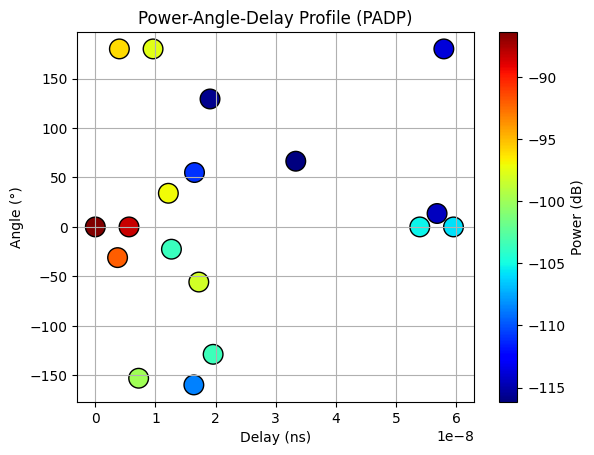

In [5]:
# tau表示每个信道的时延
print(paths.tau.numpy().squeeze())
print(paths.phi_t.numpy().squeeze() * 180 / 3.1415926)
# print(paths.tau.numpy().squeeze() * 3e8)
# print(paths.a.numpy().squeeze())
# a表示信道系数，a的幅值的平方表示接收信号的能量
# print(np.abs(paths.a.numpy().squeeze())**2)
# 用分贝形式表示
print(10 * np.log10(np.abs(paths.a.numpy().squeeze())**2))
# 每个物体经过的路径
# 0 - 木头门 | 1 - 玻璃窗 | 2 - 金属 | 3 - 墙面
print(paths.objects.numpy().squeeze())

# plt.figure()
# plt.stem(paths.tau.numpy().squeeze(), 10 * np.log10(np.abs(paths.a.numpy().squeeze())**2))
plt.figure()
plt.scatter(paths.tau.numpy().squeeze(), (paths.phi_t.numpy().squeeze() * 180 / 3.1415926)
, c=10 * np.log10(np.abs(paths.a.numpy().squeeze())**2), cmap='jet', s=200, edgecolors='k')
plt.colorbar(label="Power (dB)")
plt.xlabel("Delay (ns)")
plt.ylabel("Angle (°)")
plt.title("Power-Angle-Delay Profile (PADP)")
plt.grid(True)
plt.xlim([-0.3e-8, 6.3e-8])
plt.savefig("Result.svg")
plt.savefig("Result.png")
plt.show()

[-1  2  3  3  2  2  2  1  3  3  2  3  3  2  3  3  3  3  3  3  2  3  1  2
  0  3  1  3  3  3  2  3  3  2  3  3  2  3  3]
[ -88.17997   -90.14523   -93.81721   -97.74252   -99.960785 -105.2999
  -99.43577  -111.43867  -114.242035 -101.70299  -114.81629  -117.04437
 -124.711235 -116.186325 -126.40492  -122.60712  -121.05875  -123.76563
 -119.80781  -115.59056  -107.64957  -107.02403  -110.41928  -117.91742
 -117.55971  -112.73187  -105.38484   -98.78215  -116.21544  -118.90107
 -130.75992  -130.7682   -137.73236  -120.87788  -122.58696  -128.19254
 -120.182816 -136.28145  -123.948364]
{-1: array([88.17997], dtype=float32), 0: array([117.55971], dtype=float32), 1: array([105.38484, 110.41928, 111.43867], dtype=float32), 2: array([ 90.14523 ,  99.43577 ,  99.960785, 105.2999  , 107.64957 ,
       114.81629 , 116.186325, 117.91742 , 120.182816, 120.87788 ,
       130.75992 ], dtype=float32), 3: array([ 93.81721 ,  97.74252 ,  98.78215 , 101.70299 , 107.02403 ,
       112.73187 , 114.242035, 

<Figure size 640x480 with 0 Axes>

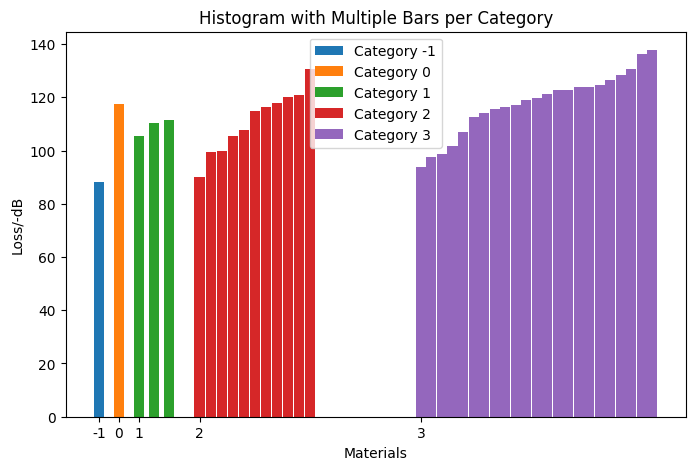

In [5]:
# and plot results
plt.figure()

# 输入数据
categories = paths.objects.numpy().squeeze()[0]
values = 10 * np.log10(np.abs(paths.a.numpy().squeeze())**2)
print(categories)
print(values)

# 找到唯一类别
unique_categories = np.unique(categories)

# 为每个类别分组数据
grouped_values = {cat: np.sort(-values[categories == cat]) for cat in unique_categories}
print(grouped_values)

# 计算柱状图的位置
bar_width = 0.2  # 每个柱子的宽度
x_positions = np.arange(len(unique_categories))  # 每个类别的 x 位置
print(x_positions)
spacing = 0.3  # 类别之间的间隔，增大此值可以使柱子之间有更多间隔

# 颜色列表（可选）
colors = ['r', 'g', 'b']

# 创建绘图
plt.figure(figsize=(8, 5))

lengths = np.insert([len(arr) for arr in grouped_values.values()], 0, 0)
spf = np.cumsum(lengths)

# 遍历类别，绘制柱状图
for i, (cat, vals) in enumerate(grouped_values.items()):
    # 为每个类别绘制多个柱子，确保它们在不同的 x 位置
    # np.linspace() 控制每个柱子在 x 轴上的具体位置，保证它们分开显示
    plt.bar(np.linspace(0, bar_width * vals.size, len(vals)) + spf[i] * bar_width * 2, 
            vals, width = bar_width, label = f'Category {cat}')

# 调整坐标轴
plt.xticks(spf[:len(grouped_values.values())] * bar_width * 2, [str(cat) for cat in unique_categories])  
plt.legend()
plt.xlabel("Materials")
plt.ylabel("Loss/-dB")
plt.title("Histogram with Multiple Bars per Category")

plt.show()